In [2]:
from segysak.segy import segy_loader,segy_header_scrape
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
import segyio
import os

In [3]:
def get_df_from_dat(path):
    fault_list = [fault for fault in os.listdir(path) if fault.endswith('.dat')]

    df = pd.DataFrame()

    for fault in fault_list:
        df_to_concat = pd.read_csv(f'{path}\{fault}', delim_whitespace=True, header=None)
        df_to_concat.columns = ['Name', 'Inline', 'Xline', 'Time', 'idk', 'n']

        i_or_x = 'iline' if fault.split('_')[1] == 'Inline' else 'xline'

        df_to_concat['Line'] = [i_or_x for _ in range(len(df_to_concat))]

        df = pd.concat([df, df_to_concat])

    df['Time'] /= 4
    df['Time'] = round(df['Time'])

    id = []
    count = -1
    for i in range(len(df)):
        if df['n'].iloc[i] == 0:
            count += 1
        id += [count]
    df['ID'] = id

    df.drop(['Name', 'idk', 'n'], axis=1, inplace=True)

    df = df[df.columns[::-1]]

    df.set_index('ID', inplace=True)

    return df

def get_mask_from_dat(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True)

In [4]:
faults_path = r'C:\Users\jpgom\Documents\Jão\git\facies_classification\Faults.dat'
cube_path = r'C:\Users\jpgom\Documents\Jão\UFBA\IC\Code\Seismic_data_w_null.sgy'

df = pd.read_csv(faults_path, delim_whitespace=True)

df

,ID,Line,Time,Xline,Inline
0,0,iline,408.0,581,310
1,0,iline,421.0,584,310
2,0,iline,439.0,588,310
3,0,iline,456.0,591,310
4,1,iline,406.0,630,310
...,...,...,...,...,...
250,62,xline,311.0,940,656
251,62,xline,342.0,940,660
252,63,xline,284.0,940,379
253,63,xline,293.0,940,375


In [25]:
#cube = segy_loader(cube_path)

100%|██████████| 619k/619k [00:48<00:00, 12.8k traces/s]


Loading as 3D
Fast direction is INLINE_3D


Converting SEGY: 100%|██████████| 619k/619k [20:01<00:00, 515 traces/s]    


Initial Values:
   Inline: 100 | Crossline: 300 | Time: 4.0


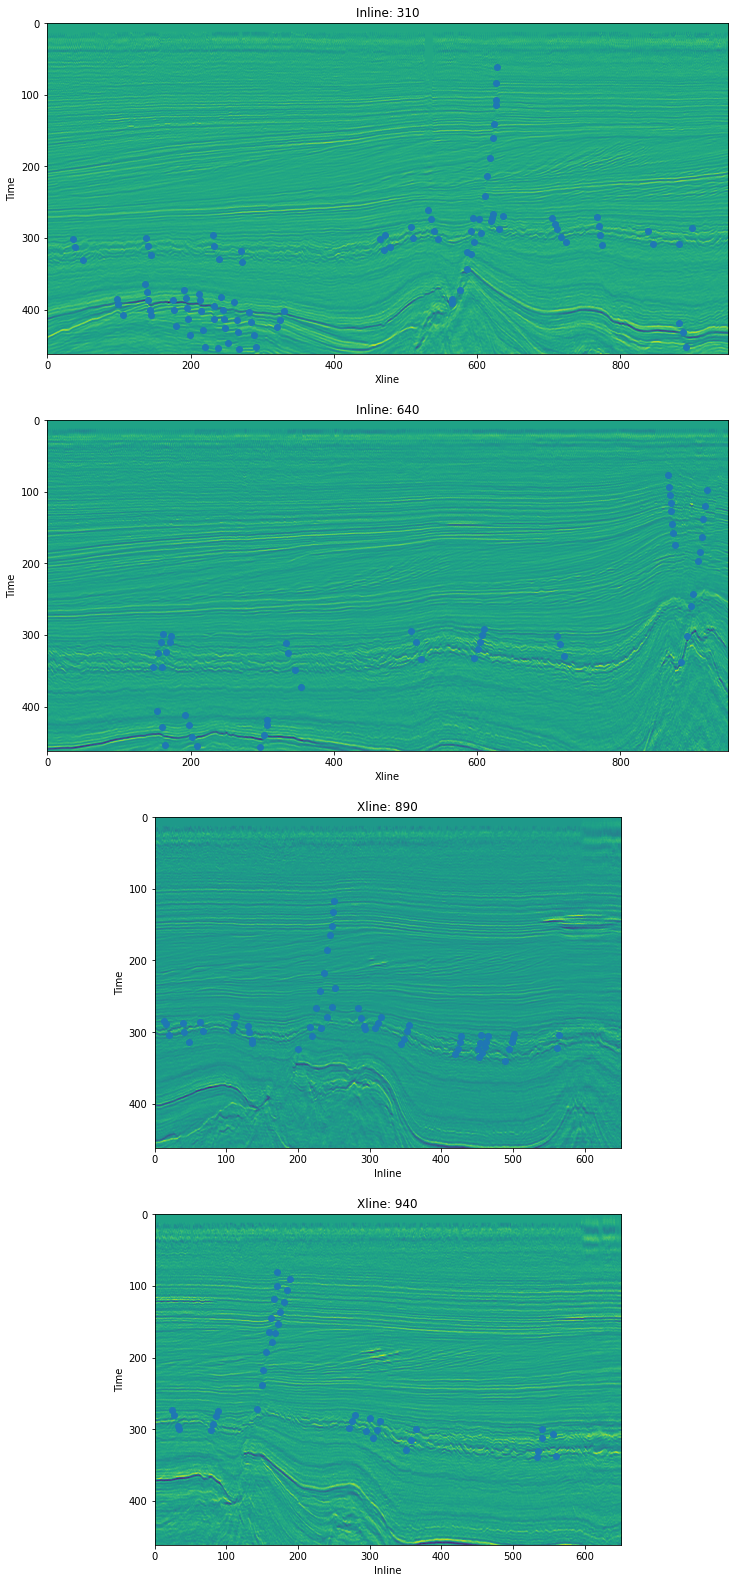

In [58]:
iline_list = cube.iline.data
xline_list = cube.xline.data
twt_list = cube.twt.data
iline0 = iline_list[0]
xline0 = xline_list[0]
twt0 = twt_list[0]

print(f'Initial Values:\n   Inline: {iline0} | Crossline: {xline0} | Time: {twt0}')

rows = len(df['Inline'][df['Line'] == 'Inline'].unique()) + len(df['Xline'][df['Line'] == 'Xline'].unique())
cols = 1

fig, ax = plt.subplots(rows, cols, figsize=(15 * cols, 7 * rows))
count = 0
for line_str in df['Line'].unique():
    for line_number in df[line_str][df['Line'] == line_str].unique():
        img = np.array(cube.sel(iline=line_number).data.T) if line_str == 'Inline' else np.array(cube.sel(xline=line_number).data.T)
        mask = np.zeros_like(img) * np.nan

        X = df['Xline'][df[line_str] == line_number][df['Line'] == line_str] - xline0 if line_str == 'Inline' else df['Inline'][df[line_str] == line_number][df['Line'] == line_str] - iline0
        Y = df['Time'][df[line_str] == line_number][df['Line'] == line_str] - twt0

        ax[count].imshow(img)
        ax[count].scatter(X, Y)
        ax[count].set_title(f'{line_str}: {line_number}')
        if line_str == 'Inline':
            for i in range(len())
            cv.line(mask, (0, 0), (3, 3), (100, 0, 0))
            ax[count].imshow(mask)
            ax[count].set_xlabel('Xline')
        else:
            ax[count].set_xlabel('Inline')
        ax[count].set_ylabel('Time')
        count += 1

In [76]:
line_str = 'Inline'
line_number = 310
img = np.array(cube.sel(iline=line_number).data.T)
mask = np.zeros_like(img)

for id in df['ID'][df['Line'] == line_str][df['Inline'] == line_number].unique():
    [cv.line(mask, (df['Xline'][df['ID'] == id].iloc[i-1], df['Time'][df['ID'] == id].iloc[i-1]), (df['Xline'][df['ID'] == id].iloc[i], df['Time'][df['ID'] == id].iloc[i]), (1,0,0)) for i in range(1, len(df['ID'][df['ID'] == id]))]

plt.imshow(mask)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
